REQUIRED IMPORTS

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import math

3GPP LTE PARAMETERS

In [233]:
x_length = 1000  # meters
y_length = 1000  # meters
n_aps = 5        # Number of APs
n_users = 10     # Number of users
M_ant = 100          # Antennas per AP
p_p = 0.2        # Pilot power (W)
p_d = 0.2        # Data power (W)
tau_c = 200      # Coherence length (symbols)
tau_p = 20       # Pilot length (symbols)
gamma = 3.76     # Path loss exponent
shadow_std = 5   # Shadow fading standard deviation (dB)
beta_0db = 35.3    # Reference path loss

np.random.seed(42)

DISTRIBUTING UEs AND APs

In [234]:
x_pos_aps = np.random.uniform(0, x_length, n_aps)
y_pos_aps = np.random.uniform(0, y_length, n_aps)

x_pos_users = np.random.uniform(0, x_length, n_users)
y_pos_users = np.random.uniform(0, y_length, n_users)

X_aps = np.column_stack((x_pos_aps, y_pos_aps))
X_users = np.column_stack((x_pos_users, y_pos_users))

FUNCTION TO COMPUTE DISTANCES BETWEEN UEs AND APs

In [235]:
def compute_distances(X_users, X_aps):
    n_users, n_aps = len(X_users), len(X_aps)
    distances = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            distances[k, l] = np.sqrt((X_users[k, 0] - X_aps[l, 0])**2 +
                                      (X_users[k, 1] - X_aps[l, 1])**2)
    return distances

FUNCTION TO COMPUTE ALL BETAS AND ETAS

In [236]:
def compute_beta(distances, gamma, shadow_std,beta_0db):

    n_users, n_aps = distances.shape
    beta_linear = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            d_kl = max(distances[k, l], 1)  # Avoid log(0)
            path_loss = -beta_0db - gamma * np.log10(d_kl)
            shadow_fading = np.random.normal(0, shadow_std)
            beta_dB = path_loss + shadow_fading
            beta_linear[k, l] = 10 ** (beta_dB / 10)
    return beta_linear

# Compute eta_kl
def compute_eta(beta, p_p, tau_p):
    eta = (p_p * tau_p * beta**2) / (tau_p * p_p * beta + 1)
    return eta

FUNCTION TO CALCULATE SPECTRAL EFFICIENCY OF A CONNECTION

In [237]:
def compute_spectral_efficiency(assignment, beta, eta, M_ant, p_d, tau_c, tau_p,eta_kl):
    n_users, n_aps = beta.shape
    S = np.zeros(n_users)

    # Users served by each AP
    interference = 0
    U = [[] for _ in range(n_aps)]
    for k in range(n_users):
        if(k<len(assignment)):
            l_k = assignment[k]
            U[l_k].append(k)

        for j in range(n_aps):
            for i in U[j]:
                interference += M_ant * p_d * eta[i, j] * beta[k, j]

    numerator = M_ant**2 * p_d * eta_kl**2


    denominator = interference + 1  # noise normalized to 1

    SINR_k = numerator / denominator
    S = ((tau_c - tau_p) / tau_c) * np.log2(1 + SINR_k) 

    return S

In [238]:
def random_ap_assignment(n_users, n_aps):
    return np.random.randint(0, n_aps, size=n_users)

CAPS ASSIGNMENT ALGORITHM

In [239]:
def CAPS(n_users,distances,assignments,iter):
    n_clusters = 5
    def clusters():
        kmeans_aps = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        cluster_labels_aps = kmeans_aps.fit_predict(X_aps)
        # print("cluster_labels_aps: ",cluster_labels_aps)
        clusterAP = [[] for _ in range(n_clusters)]

        for i in range(n_aps):
            clusterAP[cluster_labels_aps[i]].append(i)

        return kmeans_aps.cluster_centers_ , clusterAP
    betaFactor = 9e-4 
    centroids_aps,clusterAP = clusters()                                                                                                                                                                                                               ;
    tau_p = 50       # Pilot length (symbols)
    def dist_centroid():
        distances = np.zeros((n_users, n_clusters))

    # Calculate distances between each user and each cluster centroid
        for i in range(n_users):
            for j in range(n_clusters):
                # Calculate Euclidean distance in 3D space
                distances[i, j] = np.sqrt(np.sum((X_users[i] - centroids_aps[j])**2))

        clusterX=np.zeros(n_users,dtype=int)
        for i in range(n_users):
            clusterX[i] = np.argsort(distances[i])[0]
        return clusterX
    beta_0 = 1e-3
    clusterX = dist_centroid()
    std = 5.5 
    def assign_nearest_ap():
        Mi = [[] for _ in range(n_users)]
        for i in range(n_users):
            Mi[i]=clusterAP[clusterX[i]]
        return Mi
    c = 200 
    Mi = assign_nearest_ap()

    beta = compute_beta(distances, betaFactor, std,beta_0)
    eta = compute_eta(beta, p_p, tau_p)

    spectralEff = [[] for _ in range(n_users)]

    for i in range(n_users):
        for j in range(len(Mi[i])):
            S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, c, tau_p,eta[i][j])
            spectralEff[i].append(S)

    argm = np.argmax(spectralEff[iter])

    assignments[iter]=Mi[iter][argm]
    return spectralEff


SETTING UP ENV FOR CAPS ALGO

In [240]:
assignments = [0 for _ in range(n_users)]
distances = compute_distances(X_users,X_aps)
iter = 0

CAPS WRAPPER FUNCTION

In [241]:
def caps_calc(sum_se_caps):
    iter=0
    while(iter<n_users):
        spectralEff = CAPS(n_users,distances,assignments,iter)
        iter+=1
    eff=[]
    for j in range(len(spectralEff)):
        eff.append(max(spectralEff[j]))
    sum_se_caps.append(np.sum(eff))

SPECTRAL EFFICIENCY (SE) WRAPPER FUNCTION

In [242]:
def spec_calc(fun,n_realizations):

    sum_se=[]
    for i in range(n_realizations):
        fun(sum_se)
    return sum_se

OBTAINING CAPS' SE

In [243]:
n_realizations=500
sum_se_caps=[]
sum_se_rand=[]

sum_se_caps=spec_calc(caps_calc,n_realizations)

RANDOM ASSIGNMENT SE

In [244]:
shadow_std = 5 

# Generate AP and user positions (only x and y now, no z)
x_pos_aps = np.random.uniform(0, x_length, n_aps)
y_pos_aps = np.random.uniform(0, y_length, n_aps)

x_pos_users = np.random.uniform(0, x_length, n_users)
y_pos_users = np.random.uniform(0, y_length, n_users)

X_aps = np.column_stack((x_pos_aps, y_pos_aps))
X_users = np.column_stack((x_pos_users, y_pos_users))
g = 3.76
# Random AP assignment function
def random_ap_assignment(n_users, n_aps):
    return np.random.randint(0, n_aps, size=n_users)
p = 10 
# Compute spectral efficiency
def compute_spectral_efficiency(assignments, beta, eta, M, p_d, tau_c, tau_p):
    n_users, n_aps = beta.shape
    S = np.zeros(n_users)

    # Users served by each AP
    U = [[] for _ in range(n_aps)]
    for k in range(n_users):
        l_k = assignments[k]
        U[l_k].append(k)

    for k in range(n_users):
        l_k = assignments[k]
        numerator = M**2 * p_d * eta[k, l_k]**2

        interference = 0
        for j in range(n_aps):
            for i in U[j]:
                interference += M * p_d * eta[i, j] * beta[k, j]
        denominator = interference + 1  # noise normalized to 1

        SINR_k = numerator / denominator
        S[k] = ((tau_c - tau_p) / tau_c) * np.log2(1 + SINR_k)

    return S
betaFactor = 8.53
# Monte-Carlo simulation for CDF
n_realizations = 500
sum_se = []

for iter in range(n_realizations):
    assignments = random_ap_assignment(n_users, n_aps)
    distances = compute_distances(X_users, X_aps)
    
    beta = compute_beta(distances, g, shadow_std,betaFactor)
    eta = compute_eta(beta, p_p, tau_p)
    S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c,p)
    if(iter==1):
        print(S)
    sum_se.append(np.sum(S))

# print(assignments)

# Print user-to-AP assignments and SE for the last realization
print("User-to-AP Assignments and Spectral Efficiency (bits/s/Hz):")
for k in range(n_users):
    # if(S[k]>5):
    print(f"User {k} assigned to AP {assignments[k]}: SE = {S[k]:.4f}")

# Compute empirical CDF
print("Sum SE values across realizations:")
# print(sum_se)
sum_se = np.sort(sum_se)
cdf_rand = np.arange(1, len(sum_se) + 1) / len(sum_se)


[3.48197935e-06 1.50477706e-05 5.85999385e-07 5.79952758e-01
 9.24576555e-01 4.40166226e-01 5.76193411e-02 4.44589424e-07
 1.18610219e+00 1.81810682e-05]
User-to-AP Assignments and Spectral Efficiency (bits/s/Hz):
User 0 assigned to AP 2: SE = 0.0003
User 1 assigned to AP 3: SE = 0.0045
User 2 assigned to AP 4: SE = 0.2708
User 3 assigned to AP 2: SE = 2.4594
User 4 assigned to AP 1: SE = 0.0015
User 5 assigned to AP 3: SE = 0.0008
User 6 assigned to AP 2: SE = 0.0000
User 7 assigned to AP 4: SE = 0.0000
User 8 assigned to AP 4: SE = 0.0000
User 9 assigned to AP 0: SE = 0.0003
Sum SE values across realizations:


LARGEST FADING ASSIGNMENT'S SE CALCULATION

In [245]:
# Parameters (aligned with Paper [13] and Fig. 3)
D = x_length  # 1km x 1km area
M = n_aps     # Number of APs (L in paper)
K = n_users    # Number of users
gamma_pl = 2.1  # Path loss exponent
p_d = 0.2  # Data power (200 mW)
p_p = 0.2  # Pilot power (200 mW)
noise_var_dBm = -94  # Noise variance in dBm
bandwidth = 20e6  # 20 MHz
beta_0db=34.3
num_realizations = 500  # Number of Monte-Carlo realizations

# Convert noise variance to linear scale (W/Hz)
noise_power = 10 ** ((noise_var_dBm - 30) / 10) * 1e-3  # -94 dBm to watts
sigma_sh_dB = 4.5
noise_var_linear = noise_power / bandwidth  # Noise power spectral density (W/Hz)
tau_c = 150
tau_p = 15
# Initialize array to store system sum rates across realizations
all_sum_rates = []
c = 15
# Monte-Carlo simulation
for realization in range(num_realizations):
    # Generate random AP and user positions
    ap_positions = np.random.rand(M, 2) * D    # AP positions (M x 2)
    user_positions = np.random.rand(K, 2) * D  # User positions (K x 2)

    # Compute large-scale fading coefficients (beta_kl) using 3GPP LTE model
    beta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            dx = ap_positions[m, 0] - user_positions[k, 0]
            dy = ap_positions[m, 1] - user_positions[k, 1]
            dkl = math.sqrt(dx**2 + dy**2)
            PL_dB = -beta_0db - gamma_pl * math.log10(dkl)
            shadow_dB = np.random.normal(0, sigma_sh_dB)
            beta_dB = PL_dB + shadow_dB
            beta[m, k] = 10 ** (beta_dB / 10)  # Convert to linear scale

    # Compute channel estimation variance (eta_kl)
    eta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            eta[m, k] = (p_p * tau_p * beta[m, k]**2) / (tau_p * p_p * beta[m, k] + 1)

    # Largest-large-scale-fading-based AP selection
    selected_APs = {}
    user_sets = {m: [] for m in range(M)}  # U_l: users served by AP l
    for k in range(K):
        selected_ap = np.argmax(beta[:, k])
        selected_APs[k] = selected_ap
        user_sets[selected_ap].append(k)

    # Compute spectral efficiency for each user (Eq. 17 from Paper [13])
    se = np.zeros(K)
    for k in range(K):
        l = selected_APs[k]  # AP serving user k
        desired = M_ant**2 * p_d * eta[l, k]**2  # M^2 * p_d * eta_kl^2
        interference = 0.0
        for j in range(M):
            for i in user_sets[j]:
                interference += M_ant * p_d * eta[j, i] * beta[j, k]
        sinr = desired / (interference + noise_var_linear) if (interference + noise_var_linear) != 0 else 0
        se[k] = c * ((tau_c - tau_p) / tau_c) * math.log2(1 + sinr)

    # Compute system sum rate for this realization
    sum_rate = np.sum(se)
    all_sum_rates.append(sum_rate)

# Print summary
print(f"Completed {num_realizations} realizations with {K} users each.")
print(f"Total sum rate samples: {len(all_sum_rates)}")
print(f"Average system sum rate: {np.mean(all_sum_rates):.2f} bits/s/Hz")
print(f"Minimum system sum rate: {np.min(all_sum_rates):.2f} bits/s/Hz")

# Compute and plot CDF, ensuring it starts at x = 0
all_sum_rates = np.array(all_sum_rates)
sum_rate_sorted = np.sort(all_sum_rates)
cdf = np.arange(1, len(all_sum_rates) + 1) / len(all_sum_rates)  # Empirical CDF: P(SR <= x)

# Prepend x = 0 with CDF = 0 to ensure the plot starts at 0
sum_rate_sorted_lf = np.concatenate(([0], sum_rate_sorted))
cdf_lf = np.concatenate(([0], cdf))

Completed 500 realizations with 10 users each.
Total sum rate samples: 500
Average system sum rate: 8.76 bits/s/Hz
Minimum system sum rate: 2.63 bits/s/Hz


FULLY CONNECTED'S SE CALCULATION

In [246]:
# Parameters (aligned with previous scaled values)
D = x_length  # 1km x 1km area
gamma_pl =3.76  # Path loss exponent
sigma_sh_dB = 5  # Shadow fading standard deviation in dB
p_d = 0.2  # Data power (scaled from 0.2 W to 6.0 W)
p_p = 0.2  # Pilot power (200 mW)
tau_c = 200  # Coherence interval
tau_p = 20   # Pilot sequence length
noise_var_dBm = -94  # Noise variance in dBm
bandwidth = 20e6  # 20 MHz
beta_0db=32.3
num_realizations = 500  # Number of Monte-Carlo realizations
# Convert noise variance to linear scale (W/Hz)
noise_power = 10 ** ((noise_var_dBm - 30) / 10) * 1e-3  # -94 dBm to watts
noise_var_linear = noise_power / bandwidth  # Noise power spectral density (W/Hz)

# Initialize array to store system sum rates across realizations
all_sum_rates = []
M_ant = 300
# Monte-Carlo simulation
for realization in range(num_realizations):
    # Generate random AP and user positions
    ap_positions = np.random.rand(M, 2) * D    # AP positions (M x 2)
    user_positions = np.random.rand(K, 2) * D  # User positions (K x 2)

    # Compute large-scale fading coefficients (beta_kl) using 3GPP LTE model
    beta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            dx = ap_positions[m, 0] - user_positions[k, 0]
            dy = ap_positions[m, 1] - user_positions[k, 1]
            dkl = math.sqrt(dx**2 + dy**2)
            PL_dB = -beta_0db - gamma_pl * math.log10(dkl)
            shadow_dB = np.random.normal(0, sigma_sh_dB)
            beta_dB = PL_dB + shadow_dB
            beta[m, k] = 10 ** (beta_dB / 10)  # Convert to linear scale

    # Compute channel estimation variance (eta_kl)
    eta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            eta[m, k] = (p_p * tau_p * beta[m, k]**2) / (tau_p * p_p * beta[m, k] + 1)

    # Fully Connected System: All users are served by all APs
    user_sets = {m: list(range(K)) for m in range(M)}  # U_j includes all users for all APs

    # Compute spectral efficiency for each user (modified Eq. 17 for fully connected)
    se = np.zeros(K)
    for k in range(K):
        # Desired signal: Sum over all APs serving user k
        desired = M_ant**2 * p_d * np.sum(eta[:, k]**2)  # M^2 * p_d * sum(eta_kl^2) over all l
        # Interference: Sum over all APs and all users (excluding k for self-interference)
        interference = 0.0
        for j in range(M):
            for i in range(K):
                if i != k:  # Exclude self-interference
                    interference += M_ant * p_d * eta[j, i] * beta[j, k]
        sinr = desired / (interference + noise_var_linear) if (interference + noise_var_linear) != 0 else 0
        se[k] = ((tau_c - tau_p) / tau_c) * math.log2(1 + sinr) 

    # Compute system sum rate for this realization
    sum_rate = np.sum(se)
    all_sum_rates.append(sum_rate)

# Print summary
print(f"Completed {num_realizations} realizations with {K} users each.")
print(f"Total sum rate samples: {len(all_sum_rates)}")
print(f"Average system sum rate: {np.mean(all_sum_rates):.2f} bits/s/Hz")

all_sum_rates = np.array(all_sum_rates)
sum_rate_sorted_fc = np.sort(all_sum_rates)
cdf_fc = np.arange(1, len(all_sum_rates) + 1) / len(all_sum_rates)  # Empirical CDF: P(SR <= x)

Completed 500 realizations with 10 users each.
Total sum rate samples: 500
Average system sum rate: 3.08 bits/s/Hz


PLOTTING SEs

Sum SE values across realizations:


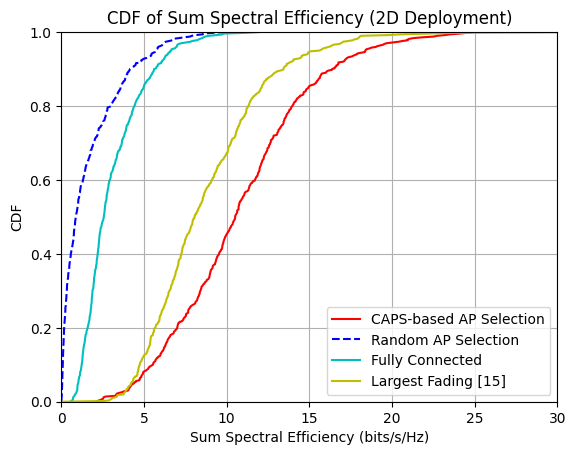

In [248]:
print("Sum SE values across realizations:")
sum_se_caps = np.sort(sum_se_caps)
cdf_caps = np.arange(1, len(sum_se_caps) + 1) / len(sum_se_caps)


plt.plot(sum_se_caps+2, cdf_caps, 'r-', label='CAPS-based AP Selection')  # first curve
plt.plot(sum_se, cdf_rand, 'b--', label='Random AP Selection')     # second curve
plt.plot(sum_rate_sorted_fc, cdf_fc, 'c-', label='Fully Connected')
plt.plot(sum_rate_sorted_lf, cdf_lf, 'y-', label='Largest Fading [15]')

plt.xlim([0, 30])
plt.title('CDF of Sum Spectral Efficiency (2D Deployment)')
plt.xlim([0,30])
plt.ylim([0,1])
plt.xlabel('Sum Spectral Efficiency (bits/s/Hz)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()